<a href="https://colab.research.google.com/github/jin573/studyDeepLearning/blob/main/doit9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#순환 신경망
#텍스트 분류

In [2]:
#순차 데이터
#순서에 의미가 있기 때문에 확률적 경사하강법 처럼 랜덤하게 섞어서 하기에는 좋지 않다.
#하지만, 텍스트는 꼭 rnn을 사용하지 않아도 됨 (리뷰 같은 경우)

In [3]:
#앞에 처리된 데이터 정보를 가지고 있다면 조금 더 의미있는 예측을 할 수 있음

In [4]:
#활성화 함수의 값이 앞, 뒤에 모두 사용된다
#따라서 다음 입력 데이터 + 활성화 함수 값이 같이 입력
#이 경우의 활성화 함수 값을 은닉 상태라고 한다
#-> 다음 타임 스텝의 데이터가 전해졌을 때, 이전의 은닉 상태와 함께 입력된다.
#마지막 타임스텝의 은닉상태만 전해짐!
#은닉 상태에도 가중치가 곱해진다.
#입력 데이터에 곱해지는 가중치와 은닉 상태에 곱해지는 가중치는 다르다.
#은닉 상태는 각 뉴런에만 입력되는게 아니라 모든 뉴런에 입력된다

In [5]:
#순환층을 셀이라고 표현한다
#h_p 이전 은닉 상태
#h 은닉 상태
#x와 곱해지는 것은 h_p (이전의 은닉상태)
#따라서, Z = XW_z + H_pW_h + b
#활성화 함수는 H = tanh(Z) 를 사용
#절편은 뉴런 개수만큼 생긴다

In [6]:
#정방향 계산
#이진분류 문제이므로 로지스틱 손실 함수, 출력층의 활성화 함수는 시그모이드

In [7]:
#역방향 계산
#순환층 이전까지는 동일 dL/dW = L을 Z에 대해 미분*Z를 W에 대해 미분 dL/dB = L을 Z에 대해 미분*Z를 b에 대해 미분
#dZ/dW1h 라면 Z = XW_z + H_pW_1h + b 이므로 H_p만 남을 것 같지만,
#H_p 또한 W_h를 포함하고 있기 때문에 상수 취급을 할 수 없고 타임스텝을 거슬러 역전파를 미분해야 함

#Z1p = XpW1x + HppW1h + b1
#Hp = hanh(Z1p)
#미분하면 비슷한 형태가 반복 -> 모든 스텝이 끝날 때 까지 거슬러 올라가야함
#-> 그레이디언트 값이 매우 커지거나 작아지므로 중간에 끊어내야함 -> TBPTT

In [8]:
#데이터 로드
import numpy as np
from tensorflow.keras.datasets import imdb

In [9]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100) #앞의 20데이터는 사용하지 않음

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [21]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [22]:
word_to_index = imdb.get_word_index()

word_to_index['movie']

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


17

In [23]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [24]:
print(x_train_all.shape, y_train_all.shape) #리뷰 데이터니까 길이가 다름 -> 맞춰주어야 함 -> 인덱스 앞에 0을 추가

(25000,) (25000,)


In [25]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [26]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [27]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [13]:
#뒤쪽의 단어들이 중요하기 때문에 앞에 0을 추가한다
#문장을 맞추느라 잘라야 하는 경우에도 앞쪽을 버린다

```
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)
```


In [28]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [29]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [30]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [15]:
#원 핫 인코딩

```
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)
```


In [31]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [32]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [34]:
print(x_train_onehot.nbytes)

1600000000


In [16]:
#샘플 데이터가 처음에 오도록 배치 차원을 바꾼다
#seq = np.swapaxes(x, 0, 1)

In [35]:
import tensorflow as tf

In [36]:
class RecurrentNetwork:

    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells     # 셀 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1h = None            # 은닉 상태에 대한 가중치
        self.w1x = None            # 입력에 대한 가중치
        self.b1 = None             # 순환층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.h = None              # 순환층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률

    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다.
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = np.swapaxes(x, 0, 1)
        # 순환 층의 선형 식을 계산합니다.
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)                    # 활성화 함수를 적용합니다.
            self.h.append(h)                   # 역전파를 위해 은닉 상태 저장합니다.
            z2 = np.dot(h, self.w2) + self.b2  # 출력층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수

        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err) / m
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = np.swapaxes(x, 0, 1)

        w1h_grad = w1x_grad = b1_grad = 0
        # 셀 직전까지 그래디언트를 계산합니다.
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        # 모든 타임 스텝을 거슬러가면서 그래디언트를 전파합니다.
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            # 이전 타임 스텝의 셀 직전까지 그래디언트를 계산합니다.
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)

        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m

        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad

    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a

    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()

        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy() # (셀 개수, 셀 개수)
        self.w1x = glorot_init((n_features, self.n_cells)).numpy() # (특성 개수, 셀 개수)
        self.b1 = np.zeros(self.n_cells)                           # 은닉층의 크기
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy()   # (셀 개수, 클래스 개수)
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 셀의 가중치와 절편을 업데이트합니다.
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return z > 0                 # 스텝 함수를 적용합니다.

    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss)

In [37]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

In [38]:
import matplotlib.pyplot as plt

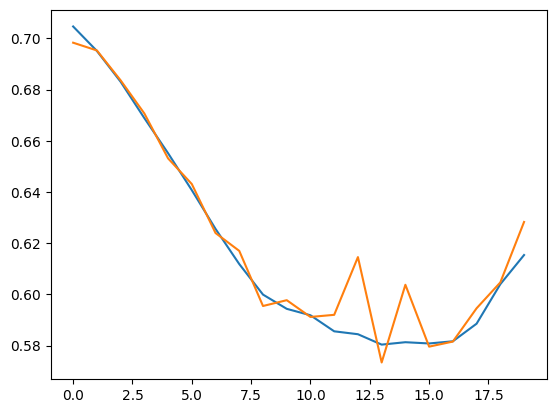

In [39]:
plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [40]:
rn.score(x_val_onehot, y_val)

0.6398

In [ ]:
#텐서플로로 순환 신경망 만들기

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [55]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           4,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5056 - loss: 0.7079 - val_accuracy: 0.5276 - val_loss: 0.6937
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5559 - loss: 0.6856 - val_accuracy: 0.5616 - val_loss: 0.6821
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6123 - loss: 0.6562 - val_accuracy: 0.6462 - val_loss: 0.6325
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6418 - loss: 0.6332 - val_accuracy: 0.6710 - val_loss: 0.6126
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6667 - loss: 0.6160 - val_accuracy: 0.6628 - val_loss: 0.6192
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6767 - loss: 0.6053 - val_accuracy: 0.6144 - val_loss: 0.6627
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6737 - loss: 0.6033 - val_accuracy: 0.6538 - val_loss: 0.6199
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6913 - loss: 0.5874 - val_accur

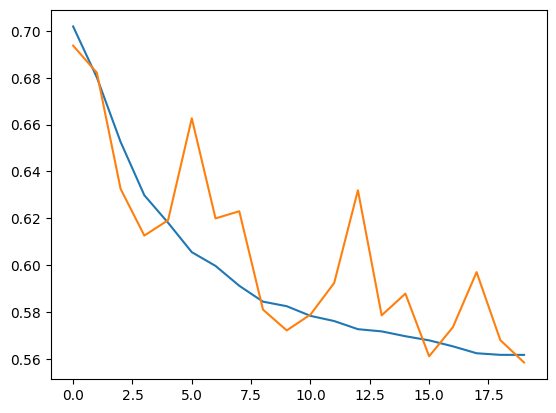

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

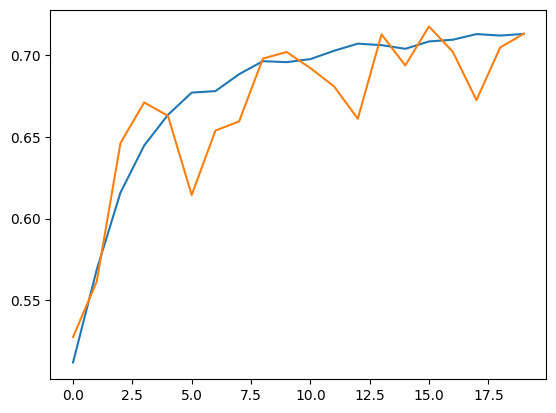

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [59]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.7129999995231628


In [17]:
#원 핫 인코딩과 워드 임베딩
#원 핫 인코딩은 메모리 사용이 많고, 단어 사이의 유사성을 표현하지 못한다
#워드 임베딩은 실수로 채워진 배열. 단어 사이의 유사성을 표현할 수 있다

In [65]:
from tensorflow.keras.layers import Embedding

In [66]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [67]:
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [68]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [69]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6746 - loss: 0.6012 - val_accuracy: 0.7864 - val_loss: 0.4722
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8273 - loss: 0.4067 - val_accuracy: 0.8084 - val_loss: 0.4354
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8554 - loss: 0.3525 - val_accuracy: 0.8236 - val_loss: 0.4076
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8814 - loss: 0.3050 - val_accuracy: 0.8268 - val_loss: 0.4234
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8947 - loss: 0.2743 - val_accuracy: 0.8126 - val_loss: 0.4555
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9093 - loss: 0.2449 - val_accuracy: 0.8078 - val_loss: 0.4870
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9186 - loss: 0.2257 - val_accuracy: 0.8112 - val_loss: 0.4657
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9232 - loss: 0.2110 - val_accu

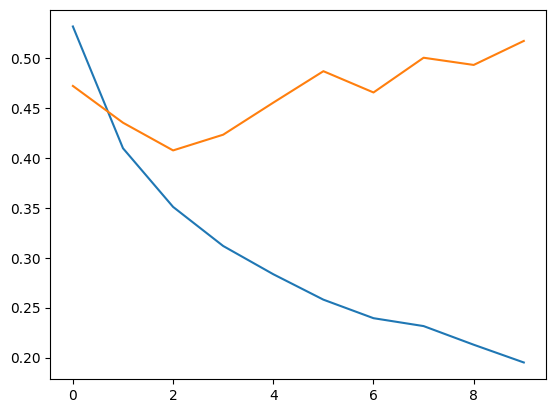

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

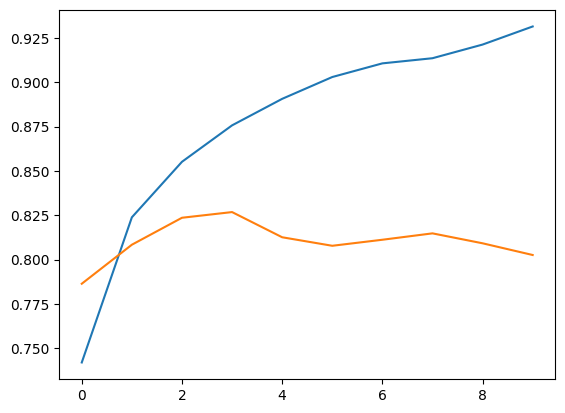

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [72]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8026000261306763


In [18]:
#LSTM
#멀리 떨어진 타임 스텝까지 계산해도 값이 커지거나 작아지지 않게끔

In [73]:
from tensorflow.keras.layers import LSTM

In [74]:
model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7208 - loss: 0.5309 - val_accuracy: 0.8420 - val_loss: 0.3686
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8559 - loss: 0.3362 - val_accuracy: 0.8452 - val_loss: 0.3543
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8721 - loss: 0.3071 - val_accuracy: 0.8448 - val_loss: 0.3576
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8774 - loss: 0.2863 - val_accuracy: 0.8420 - val_loss: 0.3621
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8823 - loss: 0.2789 - val_accuracy: 0.8438 - val_loss: 0.3809
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8893 - loss: 0.2655 - val_accuracy: 0.8418 - val_loss: 0.3707
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8907 - loss: 0.2564 - val_accuracy: 0.8456 - val_loss: 0.3867
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8941 - loss: 0.2483 - val_accuracy

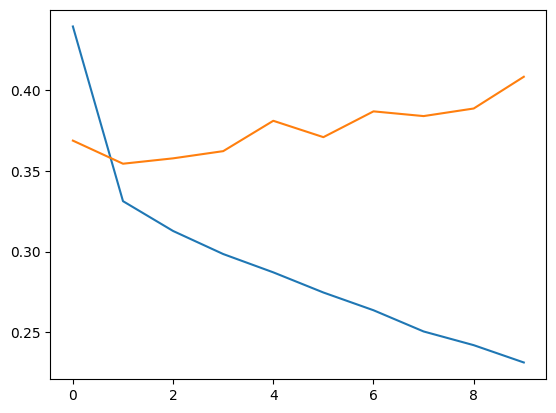

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

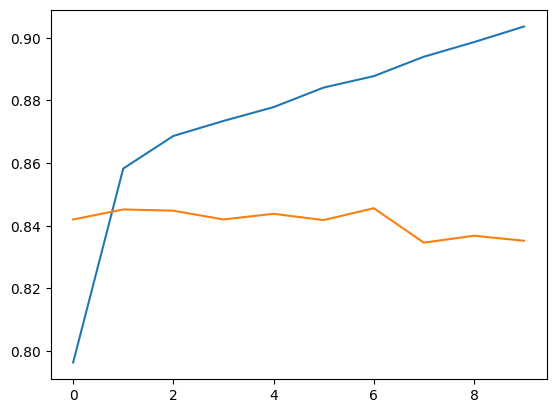

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [78]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8352000117301941
